In [1]:
# Check for GPU
!nvidia-smi

Fri Feb 28 23:30:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:01:00.0  On |                  N/A |
| N/A   44C    P5              N/A / ERR! |     47MiB /  4096MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import torch
import torch
from torch import nn

print(torch.__version__)

# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.5.1


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

To prevent underfitting means to increase the predictivity of the model.

1. Increase Model Complexity: Add more layers to the model. example: instead of using 2 layers of hidden unit, use 4 hidden layers. it will create the capability to learn the patterns.
2. Transfer Learning: It helps to prevent the underfitting by leveraging already existing/working patterns from one model/dataset and using them with your own problem.
3. Longer Training: Use more epochs to learn the patterns. Sometimes small epochs are not learning to well the patterns.


## 2. Recreate the data loading functions we built in sections 1, 2, 3 and 4 of notebook 04. You should have train and test DataLoader's ready to use.

In [3]:
# 1. get the data
import requests
import zipfile
from pathlib import Path


URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip"
# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'


# If the imgae folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f'{image_path} directory already exists... skipping download')
else:
    print(f'{image_path} directory does not exist... creating one....')
    image_path.mkdir(parents=True, exist_ok=True)


# Download pizza, steak, and sushi data
with open(data_path/ 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get(URL)
    print("Downloading pizza, steak and sushi data...")
    f.write(request.content)
    print("Download done.......")


# Unzip pizza, steak and sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print("Unzipping pizza, steak and sushi data")
    zip_ref.extractall(image_path)
    print("Extracted All....")

data/pizza_steak_sushi directory already exists... skipping download
Download done.......
Unzipping pizza, steak and sushi data
Extracted All....


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [5]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/steak/256592.jpg
Image Class: steak
Image Height: 384
Image Width: 512


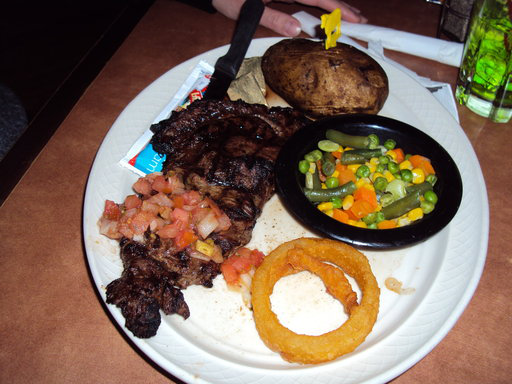

In [6]:
# Visualize an image
import random
from PIL import Image

# set random seedd
torch.manual_seed(42)

# get all image path asnd randomly choice an image
image_paths = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_paths)

# 3. Get the image class name from the path name (the image classs is the name of the directory where the image is stored)
image_class_name = random_image_path.parent.stem

# open the image
image = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Class: {image_class_name}")
print(f"Image Height: {image.height}")
print(f"Image Width: {image.width}")
image

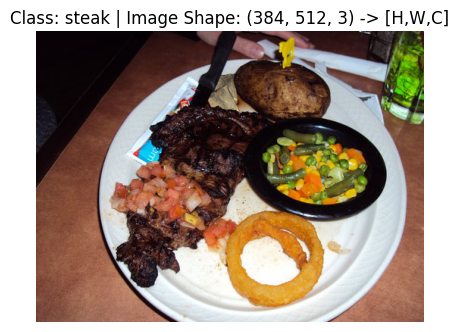

In [7]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

image_as_numpy_array = np.asarray(image)
plt.figure(figsize=(5,5))
plt.imshow(image_as_numpy_array)
plt.title(f"Class: {image_class_name} | Image Shape: {image_as_numpy_array.shape} -> [H,W,C]")
plt.axis(False)
plt.show()


We've got some images in our folders.

Now we need to make them compatible with PyTorch by:

- Transform the data into tensors.
- Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [8]:
# Transform the data
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

image_data_transform = transforms.Compose([transforms.Resize(size=(64,64)), 
                                           transforms.RandomHorizontalFlip(p=0.5),
                                           transforms.ToTensor()])

image_data_transform(image).shape

torch.Size([3, 64, 64])

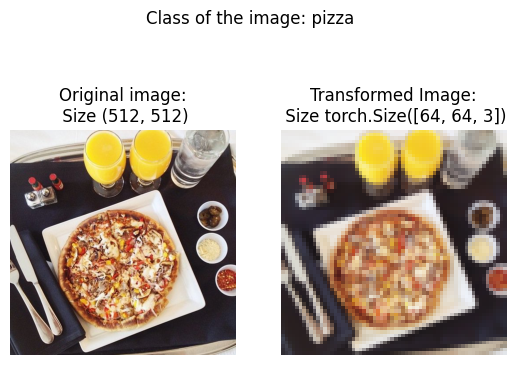

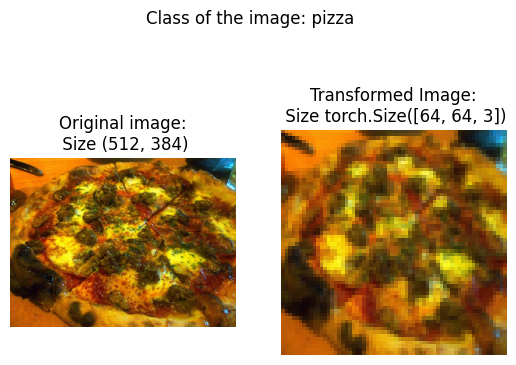

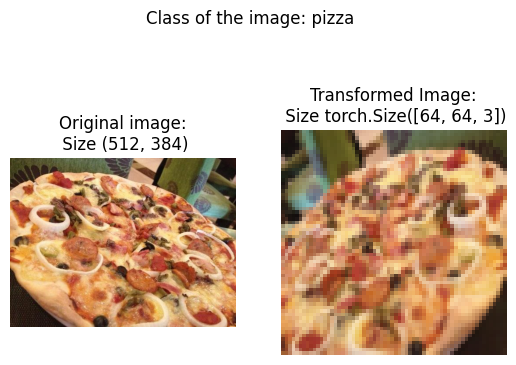

In [9]:
# Make a function which plot the 3 transformed images and the original images randomly

def plot_transformed_images(image_paths: list, transform, n: int =3, seed: int = None):
    
    """Plots a series of random images from image_paths.
        Will open n image paths from image_paths, transform them
        with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """

    if seed:
        torch.manual_seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for random_image_path in random_image_paths:
        with Image.open(random_image_path) as f:
            fig, ax = plt.subplots(nrows=1,ncols=2)

            # Plot the Original image
            ax[0].imshow(f)
            ax[0].set_title(f'Original image:\n Size {f.size}')
            ax[0].axis(False)


            # plot the transformed image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Image:\n Size {transformed_image.shape}')
            ax[1].axis(False)

            fig.suptitle(f"Class of the image: {random_image_path.parent.stem}")


plot_transformed_images(image_paths=image_paths, n=3, seed=42, transform=image_data_transform)


In [10]:
# Use ImageFolder to create dataset(s)

from torchvision import datasets

train_image_data = datasets.ImageFolder(root=train_dir, transform=image_data_transform, target_transform=None)
test_image_data = datasets.ImageFolder(root=test_dir, transform=image_data_transform, target_transform=None)
train_image_data, test_image_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [11]:
class_names = train_image_data.classes
class_dict = train_image_data.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [12]:
len(train_image_data), len(test_image_data)

(225, 75)

In [13]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE=1
train_image_dataloader = DataLoader(dataset=train_image_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
test_image_dataloader = DataLoader(dataset=test_image_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

# see what we have created
print(f"Length of train dataloaders: {len(train_image_dataloader)} batchs of {BATCH_SIZE}")
print(f"Length of test dataloaders: {len(test_image_dataloader)} batchs of {BATCH_SIZE}")

Length of train dataloaders: 225 batchs of 1
Length of test dataloaders: 75 batchs of 1


In [14]:
img, label = next(iter(train_image_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 3. Recreate model_0 we built in section 7 of notebook 04.

In [15]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_image_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [16]:
# Pass dummy data through model
dummy_x = torch.rand(size=[1, 3, 64, 64])
model_0(dummy_x.to(device))

tensor([[0.0712, 0.0686, 0.0429]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [17]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 4. Create training and testing functions for model_0.

In [18]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 
  return train_loss, train_acc 
     

In [19]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader): 
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [20]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
- Use torch.optim.Adam() with a learning rate of 0.001 as the optimizer.

In [21]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_image_dataloader,
                        test_dataloader=test_image_dataloader,
                        optimizer=optimizer,
                        epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1177 | train_acc: 0.2978 | test_loss: 1.0970 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.0999 | train_acc: 0.2889 | test_loss: 1.0994 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0993 | train_acc: 0.3244 | test_loss: 1.0996 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0987 | train_acc: 0.3422 | test_loss: 1.1037 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.1001 | train_acc: 0.2844 | test_loss: 1.0977 | test_acc: 0.3467


In [22]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_image_dataloader,
                        test_dataloader=test_image_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1177 | train_acc: 0.2978 | test_loss: 1.0971 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.0999 | train_acc: 0.3067 | test_loss: 1.0994 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0992 | train_acc: 0.3200 | test_loss: 1.0996 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0989 | train_acc: 0.3244 | test_loss: 1.0999 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0988 | train_acc: 0.3333 | test_loss: 1.1001 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.0966 | test_acc: 0.4133
Epoch: 7 | train_loss: 1.0964 | train_acc: 0.3867 | test_loss: 1.0878 | test_acc: 0.3733
Epoch: 8 | train_loss: 1.1220 | train_acc: 0.3822 | test_loss: 1.1016 | test_acc: 0.3067
Epoch: 9 | train_loss: 1.0540 | train_acc: 0.4933 | test_loss: 1.0086 | test_acc: 0.4400
Epoch: 10 | train_loss: 0.9369 | train_acc: 0.5289 | test_loss: 0.9758 | test_acc: 0.4800
Epoch: 11 | train_loss: 0.8690 | train_acc: 0.6133 | test_loss: 0.9554 | test_acc: 0.4133
Epoch: 12 | train_l

In [23]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_image_dataloader,
                        test_dataloader=test_image_dataloader,
                        optimizer=optimizer, 
                        epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1176 | train_acc: 0.2978 | test_loss: 1.0972 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.1000 | train_acc: 0.3067 | test_loss: 1.0992 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0992 | train_acc: 0.3244 | test_loss: 1.0995 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0989 | train_acc: 0.3333 | test_loss: 1.1002 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3600 | test_loss: 1.0702 | test_acc: 0.5333
Epoch: 6 | train_loss: 1.1098 | train_acc: 0.3467 | test_loss: 1.0997 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0986 | train_acc: 0.3467 | test_loss: 1.1002 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0985 | train_acc: 0.3467 | test_loss: 1.1012 | test_acc: 0.3333
Epoch: 9 | train_loss: 1.0985 | train_acc: 0.3467 | test_loss: 1.1004 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.0976 | train_acc: 0.3511 | test_loss: 1.0946 | test_acc: 0.3467
Epoch: 11 | train_loss: 1.0712 | train_acc: 0.4711 | test_loss: 1.0203 | test_acc: 0.4267
Epoch: 12 | train_l

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [25]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_3 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_image_dataloader,
                        test_dataloader=test_image_dataloader,
                        optimizer=optimizer,
                        epochs=20) # train for 20 epochs

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0891 | train_acc: 0.4178 | test_loss: 1.0569 | test_acc: 0.4667
Epoch: 2 | train_loss: 0.9956 | train_acc: 0.5600 | test_loss: 1.0141 | test_acc: 0.4800
Epoch: 3 | train_loss: 0.9614 | train_acc: 0.5556 | test_loss: 0.9807 | test_acc: 0.4800
Epoch: 4 | train_loss: 0.8893 | train_acc: 0.5867 | test_loss: 0.9662 | test_acc: 0.5200
Epoch: 5 | train_loss: 0.8497 | train_acc: 0.5822 | test_loss: 0.9926 | test_acc: 0.4000
Epoch: 6 | train_loss: 0.8113 | train_acc: 0.6400 | test_loss: 0.9663 | test_acc: 0.4933
Epoch: 7 | train_loss: 0.7860 | train_acc: 0.6711 | test_loss: 1.0658 | test_acc: 0.4667
Epoch: 8 | train_loss: 0.7303 | train_acc: 0.6800 | test_loss: 1.0516 | test_acc: 0.4800
Epoch: 9 | train_loss: 0.6650 | train_acc: 0.7244 | test_loss: 1.2107 | test_acc: 0.4400
Epoch: 10 | train_loss: 0.6270 | train_acc: 0.7556 | test_loss: 1.1933 | test_acc: 0.4400
Epoch: 11 | train_loss: 0.6234 | train_acc: 0.7556 | test_loss: 1.2005 | test_acc: 0.4400
Epoch: 12 | train_l

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?

In [26]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [27]:
# Turn the data into datasets and dataloaders
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [28]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                    transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                   transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent, 
                                         batch_size=32,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=32,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)

In [29]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_4 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_20_percent, # use double the training data
                        test_dataloader=test_dataloader_20_percent, # use double the testing data
                        optimizer=optimizer,
                        epochs=20) # train for 20 epochs

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1043 | train_acc: 0.3333 | test_loss: 1.1012 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.0883 | train_acc: 0.3521 | test_loss: 1.0816 | test_acc: 0.3426
Epoch: 3 | train_loss: 1.0473 | train_acc: 0.4271 | test_loss: 1.0051 | test_acc: 0.3807
Epoch: 4 | train_loss: 0.9206 | train_acc: 0.5938 | test_loss: 0.9199 | test_acc: 0.5557
Epoch: 5 | train_loss: 0.8681 | train_acc: 0.6312 | test_loss: 0.9214 | test_acc: 0.5335
Epoch: 6 | train_loss: 0.8307 | train_acc: 0.6396 | test_loss: 1.0865 | test_acc: 0.4062
Epoch: 7 | train_loss: 0.9061 | train_acc: 0.5646 | test_loss: 0.8766 | test_acc: 0.5682
Epoch: 8 | train_loss: 0.7492 | train_acc: 0.6792 | test_loss: 0.8594 | test_acc: 0.6415
Epoch: 9 | train_loss: 0.7450 | train_acc: 0.6625 | test_loss: 0.8718 | test_acc: 0.6028
Epoch: 10 | train_loss: 0.7542 | train_acc: 0.6792 | test_loss: 0.8840 | test_acc: 0.5977
Epoch: 11 | train_loss: 0.7031 | train_acc: 0.7063 | test_loss: 0.8665 | test_acc: 0.6659
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
- Does the model you trained in exercise 7 get it right?
- If not, what do you think you could do to improve it?

In [30]:
# Get a custom image
custom_image = "pizza_dad.jpeg"
with open("pizza_dad.jpeg", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
  f.write(request.content)

In [31]:
# Load the image
import torchvision
img = torchvision.io.read_image(custom_image)
img
     

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

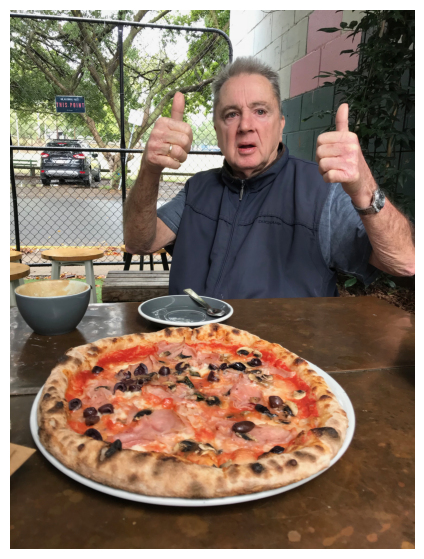

In [32]:

# View the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in HWC (height, width, color_channels) format not CHW (color_channels, height, width)
plt.axis(False);

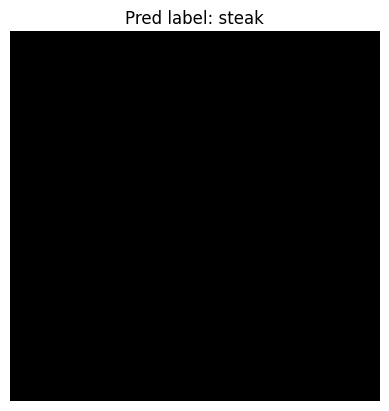

In [34]:
# Make a prediction on the image
model_4.eval()
with torch.inference_mode():
  # Get image pixels into float + between 0 and 1
  img = img / 255.

  # Resize image to 64x64
  resize = transforms.Resize((64, 64))
  img = resize(img)

  # Turn image in single batch and pass to target device
  batch = img.unsqueeze(0).to(device)

  # Predict on image
  y_pred_logit = model_4(batch) 

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);